# Introduction
The goal of this notebook is to create a clean and simple notebook that 
allows us to easily show our code to other people without having much cluttered unorganized code code.  
This is the version that does not run on colab but localy.

# Imports

In [1]:
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import pydicom as dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = [8, 6]
import scipy.signal
from pathlib import Path

import requests
from tqdm import trange
import zipfile
import os
from PIL import Image
import numpy as np
import pylab as plt
import matplotlib
from random import randint
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
from IPython.display import clear_output
import random
import shutil
%matplotlib inline

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras import regularizers
import keras.callbacks
from keras import backend as K

from tqdm import tqdm


Using TensorFlow backend.


# Global Settings
Here some global settings like filpaths and so on are declared. If this notebook is used on colab this has to be changed.

In [2]:
DATA_FOLDER = Path('./cyst_segmentation_ISMI_training_set')

# Load the data
All functions that will be needed to load the data will be definded here.

In [3]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))

In [4]:
# get path names list of raw data in ITK format
x_img_files = get_file_list(Path(DATA_FOLDER,'images/'), 'mhd')
y_img_files = get_file_list(Path(DATA_FOLDER,'annotations/'), 'mhd')

# Image class
This class will define what we see as an image. It needs the actual image, a label (if not test image) and a (file)name.

In [5]:
class Image:
  
  def __init__(self, img, label=None, name=None):
    '''
    Inputs:
    img: image as a numpy array
    label: labels of the image as np image
    name: the filename of the image
    '''
    self.img = img
    self.label = label
    self.name = name
    
   
  def get_img(self):
    return self.img
  
  def get_label(self):
    return self.label
  
  def get_name(self):
    return self.name
  
  def show_image(self):
      f, axes = plt.subplots(1, 2)
      for ax, im, t in zip(axes, 
                           (self.img, self.lbl), 
                           ('RGB image', 
                            'Manual annotation; Range: [{}, {}]'.format(self.lbl.min(), 
                                                                        self.lbl.max()))):
          ax.imshow(im)
          ax.set_title(t)

      plt.show()


# Image pre-processing
All preprocessing operations like cropping and padding or in the futur image augmentation will be done here

In [6]:
def pad_n_crop_(img, cropx, cropy, pad_mode='edge'):
    '''
    Imputs:
        img: an Image that will be padded and/or cropped
        cropx: Dimension of the x-axis
        cropy: Dimension of the y-axis
        pad_mode: Mode that is used for padding the image. Default='edge'
    Returns: 
        Returns an image that has dimensions cropx by cropy
    '''
    img = np.pad(img, ((0,0),(0,0),(0,30)), mode=pad_mode)

    _, y, x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx]

# Load and transform Images
For the sake of simplicity this here no Batch generator will be used. This should be replaced in the final version

In [7]:
images = []
'''
For each raw image file the raw image will be loaded, transformed into an np array, padded and cropped and reshaped.
Same for the Labels
For each image the filename will be extracted

An Image object (image, label filename) will be created and added to the images list.
'''
for x_file, y_file in tqdm(zip(x_img_files, y_img_files)):
  img = load_img(x_file)
  img = pad_n_crop_(img, 256, 256).reshape(img.shape[0],256,256,1)
  label = load_img(y_file)
  label = pad_n_crop_(label, 256, 256)#.reshape(img.shape[0],256,256,1)
  name = x_file.split('/')[-1] #split function is problem
  for i in range(img.shape[0]):
    image = Image(img[i,:,:], label[i,:,:], name)
    images.append(image)

122it [00:13,  8.72it/s]


# Investigate the data
This serves as a short investigation into the data. To see if everything went ok in the previous steps

In [8]:
# number of images and labels
all_labels = [image.label for image in images]
print(len(all_labels))

all_imgs = [image.img for image in images]
print(len(all_imgs))

3671
3671


In [9]:
# label distibution
targets = []
empty = []

for image in images:
  if 1 in image.label:
    targets.append(image)
  else:
    empty.append(image)
    
print(len(targets), 'Image slices contain the target variable (cyst fluid).')
print(len(empty), 'image slices do not contain cyst fliud.')

1835 Image slices contain the target variable (cyst fluid).
1836 image slices do not contain cyst fliud.


In [10]:
# compute the distribution between labls in target slices
all_ones = 0
all_zeros = 0
ratio_per_img = []
for image in targets:
    unique, counts = np.unique(image.label, return_counts=True)
    all_zeros += counts[0] 
    all_ones += counts[1]
    ratio_per_img.append(counts[1]/counts[0])
    
print('The ratio between ones and zeros is: {} (for images that contain targets)'.format(all_ones/all_zeros))
print('the average ratio per image is: {}'.format(np.mean(ratio_per_img)))

The ratio between ones and zeros is: 0.04789219181135554 (for images that contain targets)
the average ratio per image is: 0.054086053647970804


C:\Users\tpaye\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


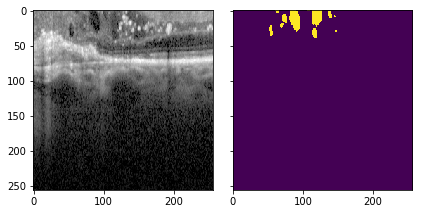

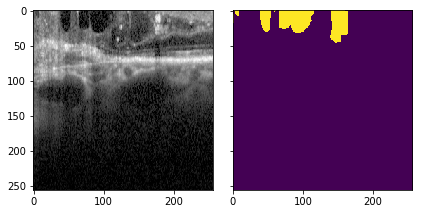

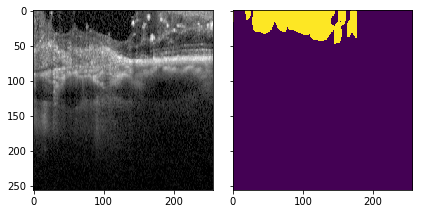

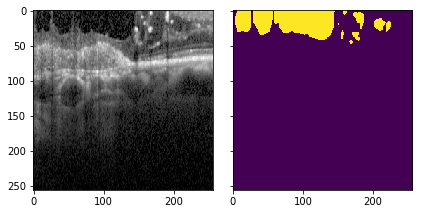

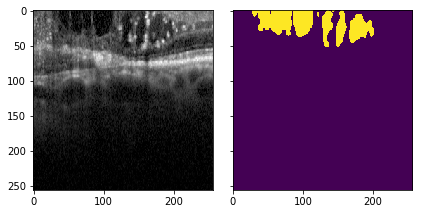

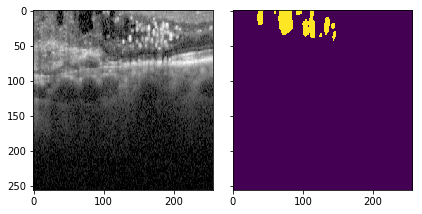

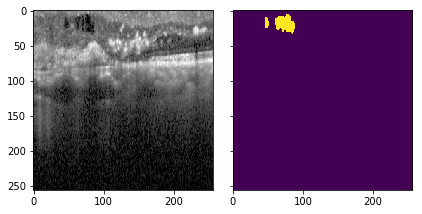

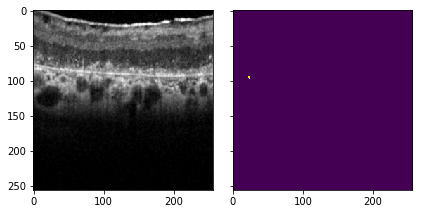

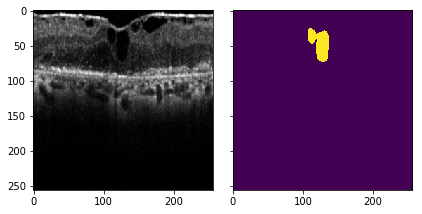

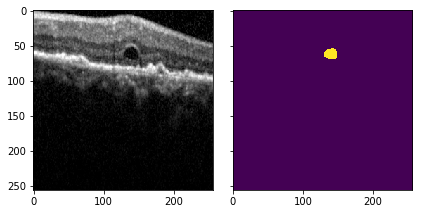

In [11]:
for i in range(10):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].imshow(targets[i].img[:,:,0], cmap='gray')
    axs[1].imshow(targets[i].label)

# Create unet
Here all building blocks of unet will be defined

In [12]:
# Create a function that builds a U-Net block, containing conv->(batchnorm->)conv->(batchnorm),
# where batchnorm is optional and can be selected via input parameter.
# The function returns the output of a convolutional (or batchnorm) layer "cl"
def unet_block(inputs, n_filters, batchnorm=False):
    
    # >> YOUR CODE HERE <<
    cl = Conv2D(n_filters,3, activation = 'relu', padding = 'same')(inputs)
    cl = BatchNormalization()(cl) if batchnorm else cl
    cl = Conv2D(n_filters,3,activation = 'relu', padding = 'same')(cl)
    cl = BatchNormalization()(cl) if batchnorm else cl
    
    return cl

In [13]:
def build_unet_2(initial_filters=16, n_classes=2, batchnorm=False, printmodel=False):

    # build U-Net again using unet_block function
    inputs = Input(shape=(256, 256, 1))

    # CONTRACTION PART

    # First conv pool
    c1 = unet_block(inputs, initial_filters, batchnorm)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, batchnorm)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, batchnorm)
    p3 = MaxPooling2D()(c3)

    # Fourth conv
    c4 = unet_block(p3, 8*initial_filters, batchnorm)

    # EXPANSION PART

    # First up-conv
    u2 = UpSampling2D()(c4)
    m2 = concatenate([c3, u2])
    cm2 = unet_block(m2, 4*initial_filters, batchnorm)

    # Second up-conv
    u3 = UpSampling2D()(cm2)
    m3 = concatenate([c2, u3])
    cm3 = unet_block(m3, 2*initial_filters, batchnorm)

    # Third up-conv
    u4 = UpSampling2D()(cm3)
    m4 = concatenate([c1, u4])
    cm4 = unet_block(m4, initial_filters, batchnorm)

    # Output
    predictions = Conv2D(n_classes, (3,3), activation='softmax', padding = 'same')(cm4)

    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

## Prepare inputs for the NN

In [14]:
# make a train and validation split

validation_percent = 0.2 
n_validation_imgs = int(validation_percent * len(images))

# coefficient to define validation dataset (value between 0 and 1)
# Do this with a more random split

# only uses images that contain fliud labels
train_data = targets[n_validation_imgs:]#images[n_validation_imgs:]
validation_data = targets[:n_validation_imgs]#images[:n_validation_imgs]

print(len(train_data))
print(len(validation_data))

1101
734


In [15]:
# create an array for all the train imgs and the labels
train_imgs = np.array([image.img for image in train_data])
train_labels = np.array([image.label for image in train_data])

validation_imgs = np.array([image.img for image in validation_data])
validation_labels = np.array([image.label for image in validation_data])

print(train_imgs.shape)
print(train_labels.shape)

(1101, 256, 256, 1)
(1101, 256, 256)


### Checkup

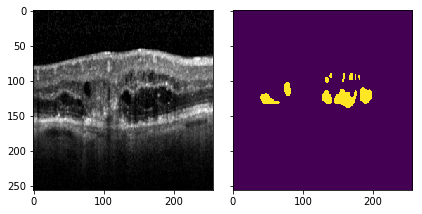

In [16]:
# again check the train images
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].imshow(train_imgs[0,:,:,0], cmap='gray')
axs[1].imshow(train_labels[0,:,:])

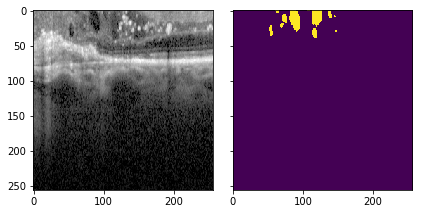

In [17]:
# again check the validation images
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[0,:,:,0], cmap='gray')
axs[1].imshow(validation_labels[0,:,:])

## Label encoding

In [18]:
# one-hot encode the labels
y_train = np.zeros((train_labels.shape[0], *(256,256), 2)) # one-hot encoding with 2 classes
for i in range(0, train_labels.shape[0]):
  lbl = train_data[0].label
  y_train[i, :, :, 1] = 1 - lbl
  y_train[i, :, :, 0] = lbl

# one-hot encode the labels
y_validation = np.zeros((validation_labels.shape[0], *(256,256), 2)) # one-hot encoding with 2 classes
for i in range(0, validation_labels.shape[0]):
  lbl = validation_data[0].label
  y_validation[i, :, :, 1] = 1 - lbl
  y_validation[i, :, :, 0] = lbl

### Checkup

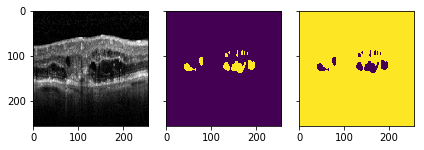

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(train_imgs[0,:,:,0], cmap='gray')
axs[1].imshow(y_train[0,:,:,0])
axs[2].imshow(y_train[0,:,:,1])

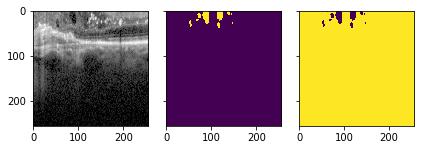

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[0,:,:,0], cmap='gray')
axs[1].imshow(y_validation[0,:,:,0])
axs[2].imshow(y_validation[0,:,:,1])

## Custom Dice loss and metric

In [44]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [22]:
# adding growth parameter for GPU memory allocation
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

## Train the model

In [39]:
from keras.callbacks import TensorBoard
tf_board_callback = keras.callbacks.TensorBoard(log_dir='./logs/normal', update_freq='batch')

model = None
model = build_unet_2(printmodel=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(train_imgs.shape)
train_imgs = train_imgs.reshape(train_imgs.shape[0], 256, 256, 1)
print(train_imgs.shape)
model.fit(train_imgs, y_train, validation_data=(validation_imgs, y_validation),  batch_size=12, epochs=10, verbose=1,
         callbacks=[tf_board_callback])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 256, 256, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_61[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 

1101/1101 [==============================] - ETA: 1:58 - loss: 9.6908 - acc: 0.030 - ETA: 1:08 - loss: 6.3945 - acc: 0.125 - ETA: 50s - loss: 4.4103 - acc: 0.401 - ETA: 41s - loss: 3.4127 - acc: 0.54 - ETA: 36s - loss: 2.8212 - acc: 0.62 - ETA: 32s - loss: 2.4249 - acc: 0.68 - ETA: 29s - loss: 2.1405 - acc: 0.72 - ETA: 27s - loss: 1.9278 - acc: 0.75 - ETA: 26s - loss: 1.7612 - acc: 0.77 - ETA: 24s - loss: 1.6268 - acc: 0.79 - ETA: 23s - loss: 1.5166 - acc: 0.81 - ETA: 22s - loss: 1.4248 - acc: 0.82 - ETA: 21s - loss: 1.3472 - acc: 0.83 - ETA: 21s - loss: 1.2805 - acc: 0.84 - ETA: 20s - loss: 1.2227 - acc: 0.85 - ETA: 19s - loss: 1.1722 - acc: 0.86 - ETA: 19s - loss: 1.1276 - acc: 0.87 - ETA: 18s - loss: 1.0880 - acc: 0.87 - ETA: 18s - loss: 1.0524 - acc: 0.88 - ETA: 17s - loss: 1.0205 - acc: 0.88 - ETA: 17s - loss: 0.9916 - acc: 0.89 - ETA: 16s - loss: 0.9653 - acc: 0.89 - ETA: 16s - loss: 0.9413 - acc: 0.89 - ETA: 16s - loss: 0.9194 - acc: 0.90 - ETA: 15s - loss: 0.8991 - acc: 0.90 - 

1101/1101 [==============================] - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 

1101/1101 [==============================] - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 12s - loss: 0.4136 - acc: 0.97 - ETA: 

1101/1101 [==============================] - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 12s - loss: 0.4136 - acc: 0.97 - ETA: 12s - loss: 0.4136 - acc: 0.97 - ETA: 

1101/1101 [==============================] - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 13s - loss: 0.4136 - acc: 0.97 - ETA: 12s - loss: 0.4136 - acc: 0.97 - ETA: 12s - loss: 0.4136 - acc: 0.97 - ETA: 

In [40]:
predictions = model.predict(validation_imgs)

In [41]:
prediction_labels = np.argmax(predictions, axis=3)

C:\Users\tpaye\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


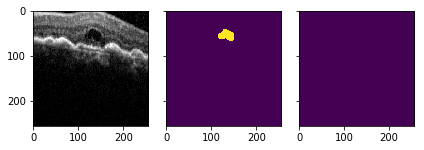

In [42]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[11,:,:,0], cmap='gray')
axs[1].imshow(validation_labels[11])
axs[2].imshow(prediction_labels[11])

## Train model with custom loss and metric

In [46]:
tf_board_callback = keras.callbacks.TensorBoard(log_dir='./logs/dice_metric', update_freq='epoch')

model = None
model = build_unet_2(printmodel=True)
model.compile(loss=dice_coef_loss, optimizer='adam', metrics=[dice_coef])

print(train_imgs.shape)
train_imgs = train_imgs.reshape(train_imgs.shape[0], 256, 256, 1)
print(train_imgs.shape)
model.fit(train_imgs, y_train, validation_data=(validation_imgs, y_validation),  batch_size=12, epochs=3, verbose=1,
         callbacks=[tf_board_callback])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 256, 256, 16) 160         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_106[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_107[0][0]                 
__________________________________________________________________________________________________
conv2d_108

1101/1101 [==============================] - ETA: 1:48 - loss: 0.0390 - dice_coef: 0.961 - ETA: 1:03 - loss: 0.0305 - dice_coef: 0.969 - ETA: 47s - loss: 0.0264 - dice_coef: 0.973 - ETA: 39s - loss: 0.0245 - dice_coef: 0.97 - ETA: 34s - loss: 0.0230 - dice_coef: 0.97 - ETA: 31s - loss: 0.0221 - dice_coef: 0.97 - ETA: 29s - loss: 0.0214 - dice_coef: 0.97 - ETA: 27s - loss: 0.0208 - dice_coef: 0.97 - ETA: 25s - loss: 0.0204 - dice_coef: 0.97 - ETA: 24s - loss: 0.0201 - dice_coef: 0.97 - ETA: 23s - loss: 0.0199 - dice_coef: 0.98 - ETA: 22s - loss: 0.0196 - dice_coef: 0.98 - ETA: 21s - loss: 0.0194 - dice_coef: 0.98 - ETA: 21s - loss: 0.0193 - dice_coef: 0.98 - ETA: 20s - loss: 0.0191 - dice_coef: 0.98 - ETA: 19s - loss: 0.0190 - dice_coef: 0.98 - ETA: 19s - loss: 0.0189 - dice_coef: 0.98 - ETA: 18s - loss: 0.0188 - dice_coef: 0.98 - ETA: 18s - loss: 0.0187 - dice_coef: 0.98 - ETA: 17s - loss: 0.0187 - dice_coef: 0.98 - ETA: 17s - loss: 0.0186 - dice_coef: 0.98 - ETA: 17s - loss: 0.0185 - 

1101/1101 [==============================] - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 19s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_

1101/1101 [==============================] - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 18s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 17s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 16s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 15s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_coef: 0.98 - ETA: 14s - loss: 0.0172 - dice_

In [47]:
predictions = model.predict(validation_imgs)

In [49]:
prediction_labels = np.argmax(predictions, axis=3)

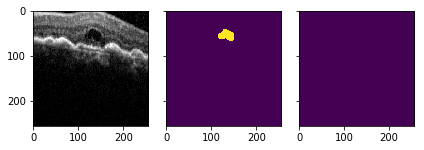

In [50]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[11,:,:,0], cmap='gray')
axs[1].imshow(validation_labels[11])
axs[2].imshow(prediction_labels[11])

## Train the network with class weight map

### Class weight function

In [54]:
def get_class_weights(training_labels):
    
    unique, counts = np.unique(training_labels, return_counts=True)
    w_background = 0.3 / (counts[0]/np.sum(counts))
    w_foreground = 0.7 / (counts[1]/np.sum(counts))
    
    # >>> YOUR CODE HERE <<<
    
    return [w_background, w_foreground]

In [55]:
get_class_weights(y_train)

[0.6, 1.4]

In [57]:
tf_board_callback = keras.callbacks.TensorBoard(log_dir='./logs/weights', update_freq='batch')

model = None
model = build_unet_2(printmodel=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(train_imgs.shape)
train_imgs = train_imgs.reshape(train_imgs.shape[0], 256, 256, 1)
print(train_imgs.shape)
model.fit(train_imgs, y_train, validation_data=(validation_imgs, y_validation),  batch_size=12, epochs=3, verbose=1,
         callbacks=[tf_board_callback], class_weight= get_class_weights(y_train))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 256, 256, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_121[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
conv2d_123

1101/1101 [==============================] - ETA: 1:57 - loss: 0.9276 - acc: 0.275 - ETA: 1:08 - loss: 0.7449 - acc: 0.553 - ETA: 51s - loss: 0.6062 - acc: 0.688 - ETA: 42s - loss: 0.5178 - acc: 0.76 - ETA: 37s - loss: 0.4743 - acc: 0.80 - ETA: 33s - loss: 0.4350 - acc: 0.83 - ETA: 31s - loss: 0.4053 - acc: 0.85 - ETA: 29s - loss: 0.3808 - acc: 0.86 - ETA: 27s - loss: 0.3569 - acc: 0.87 - ETA: 26s - loss: 0.3378 - acc: 0.88 - ETA: 25s - loss: 0.3232 - acc: 0.89 - ETA: 24s - loss: 0.3108 - acc: 0.90 - ETA: 23s - loss: 0.3015 - acc: 0.90 - ETA: 22s - loss: 0.2918 - acc: 0.91 - ETA: 21s - loss: 0.2848 - acc: 0.91 - ETA: 21s - loss: 0.2773 - acc: 0.92 - ETA: 20s - loss: 0.2708 - acc: 0.92 - ETA: 20s - loss: 0.2641 - acc: 0.92 - ETA: 19s - loss: 0.2598 - acc: 0.92 - ETA: 19s - loss: 0.2547 - acc: 0.93 - ETA: 18s - loss: 0.2511 - acc: 0.93 - ETA: 18s - loss: 0.2464 - acc: 0.93 - ETA: 17s - loss: 0.2417 - acc: 0.93 - ETA: 17s - loss: 0.2385 - acc: 0.93 - ETA: 16s - loss: 0.2350 - acc: 0.93 - 

1101/1101 [==============================] - ETA: 17s - loss: 0.0956 - acc: 0.97 - ETA: 18s - loss: 0.0959 - acc: 0.97 - ETA: 18s - loss: 0.0961 - acc: 0.97 - ETA: 17s - loss: 0.0957 - acc: 0.97 - ETA: 17s - loss: 0.0959 - acc: 0.97 - ETA: 17s - loss: 0.0958 - acc: 0.97 - ETA: 17s - loss: 0.0957 - acc: 0.97 - ETA: 17s - loss: 0.0956 - acc: 0.97 - ETA: 17s - loss: 0.0955 - acc: 0.97 - ETA: 17s - loss: 0.0958 - acc: 0.97 - ETA: 16s - loss: 0.0955 - acc: 0.97 - ETA: 16s - loss: 0.0956 - acc: 0.97 - ETA: 16s - loss: 0.0957 - acc: 0.97 - ETA: 16s - loss: 0.0959 - acc: 0.97 - ETA: 16s - loss: 0.0961 - acc: 0.97 - ETA: 15s - loss: 0.0961 - acc: 0.97 - ETA: 15s - loss: 0.0962 - acc: 0.97 - ETA: 15s - loss: 0.0962 - acc: 0.97 - ETA: 15s - loss: 0.0962 - acc: 0.97 - ETA: 14s - loss: 0.0962 - acc: 0.97 - ETA: 14s - loss: 0.0961 - acc: 0.97 - ETA: 14s - loss: 0.0961 - acc: 0.97 - ETA: 14s - loss: 0.0962 - acc: 0.97 - ETA: 14s - loss: 0.0963 - acc: 0.97 - ETA: 13s - loss: 0.0963 - acc: 0.97 - ETA: 

In [58]:
predictions = model.predict(validation_imgs)

In [59]:
prediction_labels = np.argmax(predictions, axis=3)

C:\Users\tpaye\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


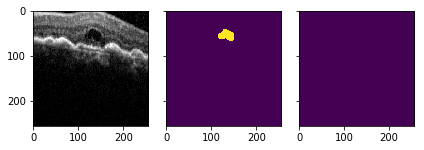

In [60]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[11,:,:,0], cmap='gray')
axs[1].imshow(validation_labels[11])
axs[2].imshow(prediction_labels[11])

In [61]:
prediction_labels.shape

(734, 256, 256)

## Train model with SGD optimizer

In [62]:
tf_board_callback = keras.callbacks.TensorBoard(log_dir='./logs/sgd', update_freq='batch')

model = None
model = build_unet_2(printmodel=True)
sgd = SGD(lr=0.0001, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(train_imgs.shape)
train_imgs = train_imgs.reshape(train_imgs.shape[0], 256, 256, 1)
print(train_imgs.shape)
model.fit(train_imgs, y_train, validation_data=(validation_imgs, y_validation),  batch_size=12, epochs=3, verbose=1,
         callbacks=[tf_board_callback])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_136[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_137[0][0]                 
__________________________________________________________________________________________________
conv2d_138

1101/1101 [==============================] - ETA: 1:58 - loss: 2.1020 - acc: 0.262 - ETA: 1:09 - loss: 1.2036 - acc: 0.617 - ETA: 51s - loss: 0.9413 - acc: 0.736 - ETA: 42s - loss: 0.8130 - acc: 0.79 - ETA: 37s - loss: 0.7362 - acc: 0.83 - ETA: 33s - loss: 0.6825 - acc: 0.85 - ETA: 31s - loss: 0.6441 - acc: 0.87 - ETA: 29s - loss: 0.6158 - acc: 0.88 - ETA: 27s - loss: 0.5934 - acc: 0.89 - ETA: 26s - loss: 0.5754 - acc: 0.90 - ETA: 25s - loss: 0.5607 - acc: 0.90 - ETA: 24s - loss: 0.5485 - acc: 0.91 - ETA: 23s - loss: 0.5381 - acc: 0.91 - ETA: 22s - loss: 0.5292 - acc: 0.92 - ETA: 21s - loss: 0.5215 - acc: 0.92 - ETA: 21s - loss: 0.5147 - acc: 0.92 - ETA: 20s - loss: 0.5088 - acc: 0.93 - ETA: 19s - loss: 0.5035 - acc: 0.93 - ETA: 19s - loss: 0.4988 - acc: 0.93 - ETA: 18s - loss: 0.4945 - acc: 0.93 - ETA: 18s - loss: 0.4907 - acc: 0.94 - ETA: 18s - loss: 0.4872 - acc: 0.94 - ETA: 17s - loss: 0.4840 - acc: 0.94 - ETA: 17s - loss: 0.4810 - acc: 0.94 - ETA: 16s - loss: 0.4783 - acc: 0.94 - 

1101/1101 [==============================] - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 18s - loss: 0.4136 - acc: 0.97 - ETA: 18s - loss: 0.4136 - acc: 0.97 - ETA: 18s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 17s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 16s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 15s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 14s - loss: 0.4136 - acc: 0.97 - ETA: 

In [63]:
predictions = model.predict(validation_imgs)

In [64]:
prediction_labels = np.argmax(predictions, axis=3)

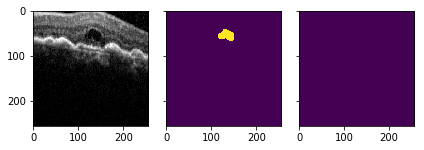

In [65]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].imshow(validation_imgs[11,:,:,0], cmap='gray')
axs[1].imshow(validation_labels[11])
axs[2].imshow(prediction_labels[11])